In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def getYellowTaxiDataset(year, months):
  dfs = []
  for i in months:
    df = pd.read_parquet(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{str(i).zfill(2)}.parquet')
    df.columns = [colName.lower() for colName in df.columns]
    dfs.append(df)
  
  return pd.concat(dfs)

In [3]:
def getTripDuration(df):
  df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).apply(lambda x: x.total_seconds() / 60)
  return df

In [4]:
def selectVariables(df, categorical, numerical, target):
  df[categorical] = df[categorical].astype(str)

  return df[categorical + numerical + target]

In [5]:
def removeOutliers(df):
  return df.loc[(df.duration >= 1) & (df.duration <= 60), :]

In [6]:
df = getYellowTaxiDataset(2023, [1])
print("Raw data columns count:", df.shape[1])
raw_records_count = df.shape[0]
df = getTripDuration(df)
print("Standard deviation of trip duration", round(df.duration.std(), 2))

categoricalCols = ['pulocationid', 'dolocationid']
numericalCols = []
targetCol = ['duration']

df = selectVariables(df, categoricalCols, numericalCols, targetCol)
df = removeOutliers(df)
print("Fraction of records left outlier removal", round(100*df.shape[0] / raw_records_count, 2))

Raw data columns count: 19
Standard deviation of trip duration 42.59
Fraction of records left outlier removal 98.12


In [7]:
def fitVectorizer(df, categorical, numerical):
  df[categorical] = df[categorical].astype(str)

  # one-hot encoding for categorical variables
  df_dicts = df[categorical + numerical].to_dict(orient='records')
  dv = DictVectorizer()
  dv.fit(df_dicts)
  return dv

In [8]:
dv = fitVectorizer(df, categoricalCols, numericalCols)
print("Number of transformed features:", len(dv.get_feature_names_out()))

Number of transformed features: 515


In [9]:
def transformInputs(df, dv):
  df_dicts = df.to_dict(orient='records')
  X = dv.transform(df_dicts)

  return X

In [10]:
X = transformInputs(df, dv)
y = df.duration

In [11]:
def trainModel(model, X, y):
  model.fit(X, y)

  return model

In [12]:
def testModel(model, X, y):
  preds = model.predict(X)

  sns.histplot(preds, kde=True)
  sns.histplot(y, kde=True)
  
  return root_mean_squared_error(y, preds)

Training MSE: 7.65


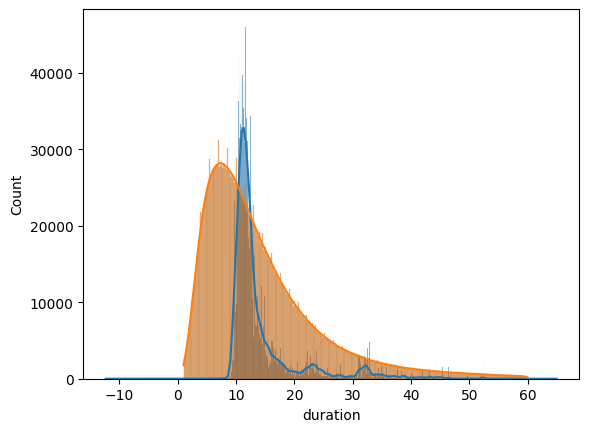

In [13]:
lr = trainModel(LinearRegression(), X, y)
mse = testModel(lr, X, y)
print("Training MSE:", round(mse, 2))

In [14]:
test_df = getYellowTaxiDataset(2023, [2])
test_df = getTripDuration(test_df)
test_df = selectVariables(test_df, categoricalCols, numericalCols, targetCol)
test_df = removeOutliers(test_df)

In [15]:
X_test = transformInputs(test_df, dv)
y_test = test_df.duration

Testing MSE: 7.81


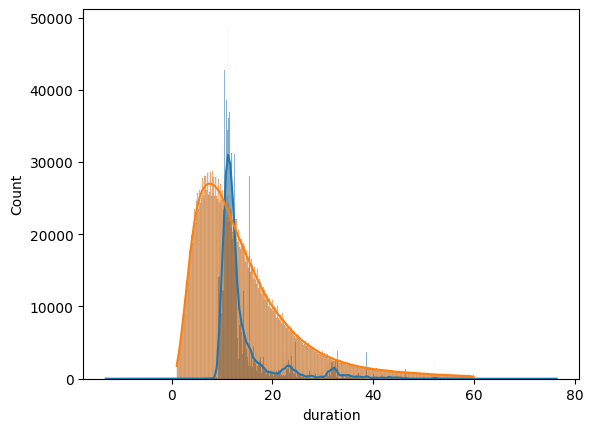

In [16]:
mse_test = testModel(lr, X_test, y_test)
print("Testing MSE:", round(mse_test, 2))